In [2]:
import torch
import numpy as np
from nn.rrdbunet import UNetRRDB2 # Load a modeltype
#Plotting stuff
from utils.visualize import plot_matrices, plot_insulation_scores
from utils.metrics import calculate_insulation_score


/home/muadip/miniforge3/envs/ccut/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#instatitate model and push to gpu
unet = UNetRRDB2(in_channels=1, out_channels=1, features=[64, 128, 256, 512, 1024]).to('cuda:0')

In [4]:
# Load weitghts from training
unet.load("./models/unet-1024-50x50-porec-4x-tvloss.pth")

In [5]:
# Load low res and high res ccdata from numpy (can be created with 
#
# python convert_and_normalize_v3.py SRR11589414_1_4x_v2.mcool::/resolutions/50000 --prefix <filename_prefix> --output_path <your/outpudir/> --processes 9 --chromosomes 1-18  --cutoff 71 --norm
# cutoff is a value to cap all interactions at -> 71 is the 99.9th percentile for the pore-c data
# norm will norm the data between 0-1.
# This method prepares the data in numpy format making it easy to handle in python. Otherwise the the CC_Dataset class can achieve the same with hot-loading
# )

chr19_lr = np.load(
    "../data/porec-4x-perc999-hr_cutoff-norm-chr19-22-50k-chromosomes.npz"
)["chr19"]
chr19_hr = np.load(
    "../data/porec-perc999-hr_cutoff-norm-chr19-22-50k-chromosomes.npz"
)["chr19"]

In [6]:
# Predict a patch (device will be automagically the same as the model lives on if you don't specify otherwise)
unet.predict_patch(chr19_lr[200:240,200:240])

array([[ 1.0157495e+00,  7.4041897e-01,  2.9994795e-01, ...,
         2.6288256e-03,  3.2095984e-03,  5.2014738e-04],
       [ 7.3225957e-01,  9.8515886e-01,  7.5991422e-01, ...,
        -1.0466129e-03, -2.9191375e-05,  2.5400743e-03],
       [ 3.0521148e-01,  7.5566781e-01,  9.8743409e-01, ...,
         2.5576502e-03,  2.8605461e-03,  1.9998848e-02],
       ...,
       [ 5.8427528e-03,  1.4849529e-03,  2.9119924e-03, ...,
         1.0066196e+00,  9.2514855e-01,  5.5267620e-01],
       [ 5.0805211e-03,  1.7879680e-03,  3.1805709e-03, ...,
         9.3723267e-01,  9.9766952e-01,  5.9714240e-01],
       [-4.2229146e-04,  3.0374154e-03,  2.1186210e-02, ...,
         5.6333464e-01,  6.2424743e-01,  9.5659262e-01]], dtype=float32)

In [7]:
# predict a whole chromosome (device will be automagically the same as the model lives on if you don't specify otherwise)
chr19_pred = unet.reconstruct_matrix(lr= chr19_lr, patch_size=40)

100%|██████████| 30/30 [00:14<00:00,  2.02it/s]


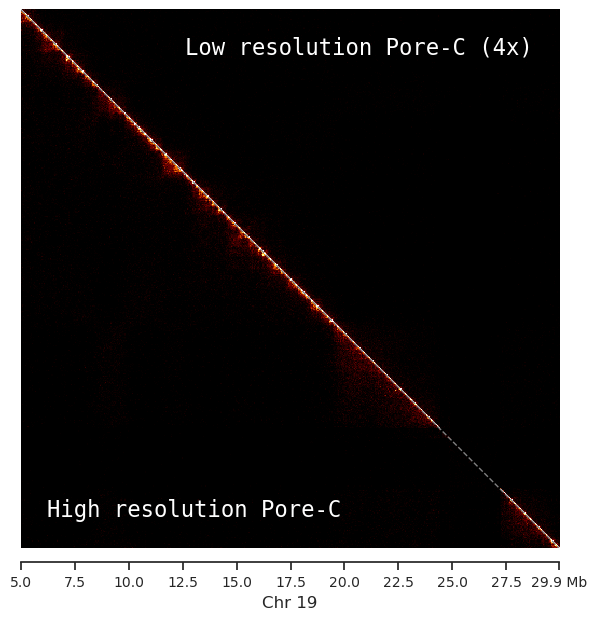

In [13]:
plot_matrices(
    np.squeeze(chr19_lr[100:600, 100:600]),
    np.squeeze(chr19_hr[100:600, 100:600]),
    chromosome="Chr 19",
    start_pos=100*50_000,
    resolution=50_000,
    cmap="afmhot",
    tick_interval=50,
    text_lower_left="High resolution Pore-C",
    text_upper_right="Low resolution Pore-C (4x)",
    diag=True,
    figsize=(7,7)
)

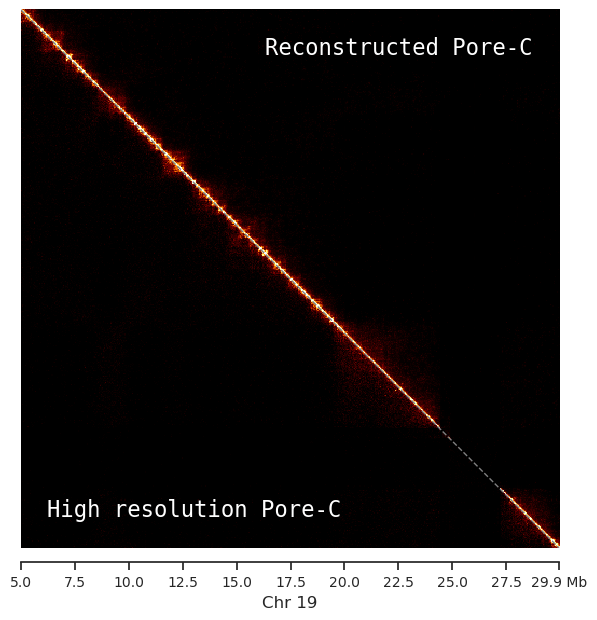

In [14]:
plot_matrices(
    np.squeeze(chr19_pred[100:600, 100:600]),
    np.squeeze(chr19_hr[100:600, 100:600]),
    chromosome="Chr 19",
    start_pos=100*50_000,
    resolution=50_000,
    cmap="afmhot",
    tick_interval=50,
    text_lower_left="High resolution Pore-C",
    text_upper_right="Reconstructed Pore-C",
    diag=True,
    figsize=(7,7)
)

In [10]:
# Calculate insulation profiles for biological validation
window_size1 = 3
insulation_scores_pred1 = calculate_insulation_score(chr19_pred, window_size1)
insulation_scores_lr1 = calculate_insulation_score(chr19_lr, window_size1)
insulation_scores_hr1 = calculate_insulation_score(chr19_hr, window_size1)
window_size2 = 5
insulation_scores_pred2 = calculate_insulation_score(chr19_pred, window_size2)
insulation_scores_lr2 = calculate_insulation_score(chr19_lr, window_size2)
insulation_scores_hr2 = calculate_insulation_score(chr19_hr, window_size2)

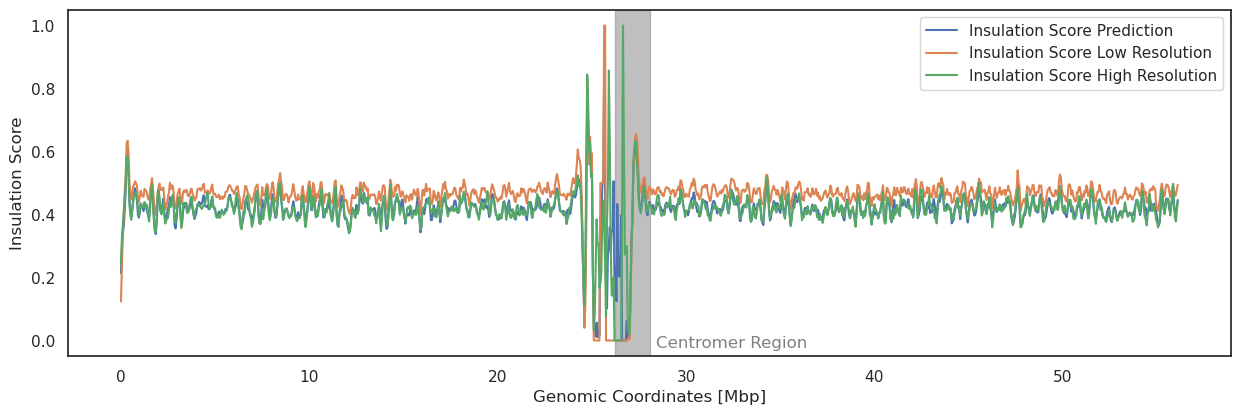

In [11]:
import matplotlib.pyplot as plt
import numpy as np


plot_insulation_scores(
    insulation_scores_pred1,
    insulation_scores_lr1,
    insulation_scores_hr1,
    start_pos=0,
    resolution=50_000,
    figsize=(15, 4.5),
)

In [ ]:
np.save('chr19_predictions_pore-c', chr19_pred)